In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from utils.utils import IoU
from TverskyLoss.binarytverskyloss import BinaryTverskyLoss
from DiceLoss.multi_dice_loss import MultiDiceLoss
from LovaszSoftmax.lovasz_loss import LovaszSoftmax

In [2]:
image_path='./Data/ProstateX-0002/t2w.mhd'
seg_path='./Data/ProstateX-0002/seg.mhd'
itkimage=sitk.ReadImage(image_path)
image=sitk.GetArrayFromImage(itkimage)

itkimage=sitk.ReadImage(seg_path)
seg=sitk.GetArrayFromImage(itkimage)

scale=0.2
image=np.transpose(image,(1,2,0))
seg=np.transpose(seg,(1,2,0))

hei,wid,_=image.shape

image=cv2.resize(image,(int(scale*wid),int(scale*hei)),cv2.INTER_CUBIC)
seg=cv2.resize(seg,(int(scale*wid),int(scale*hei)),cv2.INTER_NEAREST)
image=np.transpose(image,(2,0,1))
seg=np.transpose(seg,(2,0,1))
print(seg.shape)

(19, 76, 76)


In [3]:
image=np.asarray(image,dtype=np.float32)
image=(image-np.mean(image))/np.std(image)
image=np.expand_dims(image,0)
seg=np.asarray(seg,np.int64)
data=torch.from_numpy(image)
target=torch.from_numpy(seg)
data=data.unsqueeze(0).cuda()
target=target.unsqueeze(0).cuda()

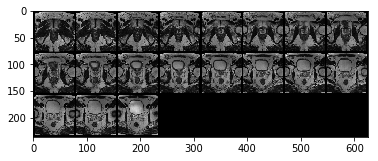

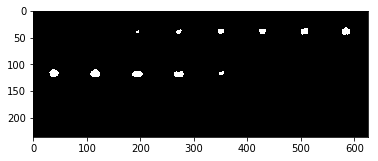

In [4]:
tmp=data.squeeze(1)
tmp=tmp.permute(1,0,2,3)
grid=make_grid(tmp,nrow=8,normalize=True)
grid_tmp=grid.cpu().numpy()
grid_tmp=np.transpose(grid_tmp,(1,2,0))
plt.imshow(grid_tmp)
plt.show()

tmp=target.permute(1,0,2,3)
grid=make_grid(tmp,nrow=8)
grid_tmp=grid.cpu().numpy()
grid_tmp=np.transpose(grid_tmp,(1,2,0))
plt.imshow(grid_tmp*255,cmap='gray')
plt.show()

In [5]:
class Net(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Net, self).__init__()
        self.Conv1=nn.Sequential(
            nn.Conv3d(in_channels,32,3,padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU()
        )
        self.Conv2=nn.Sequential(
            nn.Conv3d(32,64,3,padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU()
        )
        self.Conv3=nn.Sequential(
            nn.Conv3d(64,out_channels,3,padding=1),
            nn.Softmax(dim=1)
        )
    def forward(self,input):
        out=self.Conv1(input)
        out=self.Conv2(out)
        out=self.Conv3(out)
        return out
        

##  Dice Loss

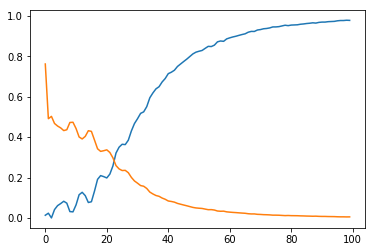

0.005641043186187744


In [12]:
iters=100
model=Net(1,2).cuda()
optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.99))
dice_loss=MultiDiceLoss([0.5,0.5],num_class=2)
ious=[]
losses=[]
for i in range(iters):
    optimizer.zero_grad()
    out1=model(data)
    loss,_=dice_loss(out1,target)
    loss.backward()
    optimizer.step()
    _,pred1=out1.max(1)
    iou=IoU(pred1.cpu().numpy(),target.cpu().numpy())
    ious.append(iou)
    losses.append(loss.item())
plt.plot(ious)
plt.plot(losses)
plt.show()
print(np.min(losses))

## Lovasz Softmax

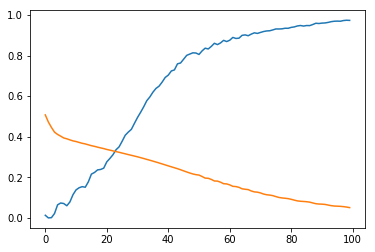

0.050817009061574936


In [13]:
iters=100
model=Net(1,2).cuda()
optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.99))

ious=[]
losses=[]
for i in range(iters):
    lovasz_loss=LovaszSoftmax()
    optimizer.zero_grad()
    out1=model(data)
    loss=lovasz_loss(out1,target)
    loss.backward()
    optimizer.step()
    _,pred1=out1.max(1)
    iou=IoU(pred1.cpu().numpy(),target.cpu().numpy())
    ious.append(iou)
    losses.append(loss.item())
plt.plot(ious)
plt.plot(losses)
plt.show()
print(np.min(losses))

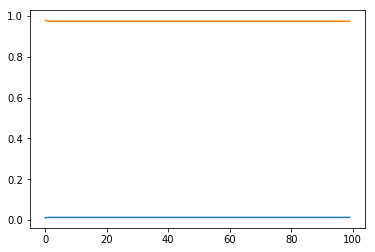

0.9748463034629822


In [7]:
iters=100
model=Net(1,2).cuda()
optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.99))

ious=[]
losses=[]
for i in range(iters):
    tversky_loss=BinaryTverskyLoss(alpha=0.5,beta=0.5)
    optimizer.zero_grad()
    out1=model(data)
    loss=tversky_loss(out1,target)
    loss.backward()
    optimizer.step()
    _,pred1=out1.max(1)
    iou=IoU(pred1.cpu().numpy(),target.cpu().numpy())
    ious.append(iou)
    losses.append(loss.item())
plt.plot(ious)
plt.plot(losses)
plt.show()
print(np.min(losses))

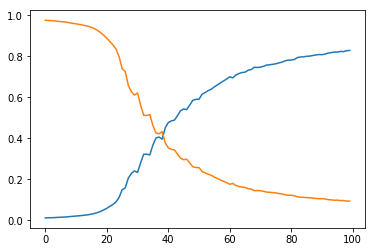

0.09389668703079224


In [6]:
iters=100
model=Net(1,2).cuda()
optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.99))

ious=[]
losses=[]
for i in range(iters):
    tversky_loss=BinaryTverskyLoss(alpha=0.5,beta=0.5)
    optimizer.zero_grad()
    out1=model(data)
    loss=tversky_loss(out1,target)
    loss.backward()
    optimizer.step()
    _,pred1=out1.max(1)
    iou=IoU(pred1.cpu().numpy(),target.cpu().numpy())
    ious.append(iou)
    losses.append(loss.item())
plt.plot(ious)
plt.plot(losses)
plt.show()
print(np.min(losses))

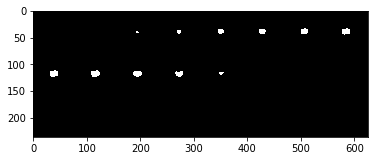

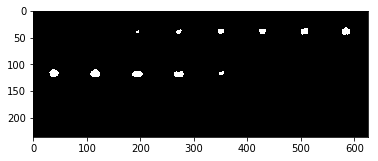

IoU: 0.8141529658226211


In [15]:
_,pred1=out1.max(1)
tmp=pred1.permute(1,0,2,3)
grid=make_grid(tmp,nrow=8)
grid_tmp=grid.cpu().numpy()
grid_tmp=np.transpose(grid_tmp,(1,2,0))
plt.imshow(grid_tmp*255,cmap='gray')
plt.show()

diff=(target).abs()
tmp=diff.permute(1,0,2,3)
grid=make_grid(tmp,nrow=8)
grid_tmp=grid.cpu().numpy()
grid_tmp=np.transpose(grid_tmp,(1,2,0))
plt.imshow(grid_tmp*255,cmap='gray')
plt.show()

print('IoU: {}'.format(IoU(pred1.cpu().numpy(),target.cpu().numpy())))